In [11]:
from bitarray import bitarray
import random
import numpy as np
import math
import timeit

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [14]:
import pandas as pd
import os

In [15]:
import sklearn.datasets as skds
from sklearn.datasets import fetch_openml

In [16]:
n=25000
n=4*(n//4)

mu11=5
mu12=12
mu1=[mu11,mu12]
sig11=50
sig12=70
cov1=[[sig11,0],[0,sig12]]
x1 = np.random.multivariate_normal(mu1,cov1,n//4)

mu21=60
mu22=100
mu2=[mu21,mu22]
sig21=30
sig22=15
cov2=[[sig21,0],[0,sig22]]
x2 = np.random.multivariate_normal(mu2,cov2,n//4)

mu31=-30
mu32=50
mu3=[mu31,mu32]
sig31=50
sig32=45
cov3=[[sig31,0],[0,sig32]]
x3 = np.random.multivariate_normal(mu3,cov3,n//4)

mu41=70
mu42=-50
mu4=[mu41,mu42]
sig41=45
sig42=75
cov4=[[sig41,0],[0,sig42]]
x4 = np.random.multivariate_normal(mu4,cov4,n//4)

mu51=-90
mu52=-20
mu5=[mu51,mu52]
sig51=30
sig52=60
cov5=[[sig51,0],[0,sig52]]
x5 = np.random.multivariate_normal(mu5,cov5,n//4)

x_n = np.concatenate((x1,x2,x5))
np.random.shuffle(x_n)

X=np.concatenate((x_n,x3,x4))
X = StandardScaler().fit_transform(X)

In [17]:

x_train = X[6250:]
x_test=X[:6250]
y_test=np.zeros(int((n//4)))

y_train = np.concatenate((np.zeros(int(n//2)),np.ones(int(n//4)),np.ones(n//4))).reshape(-1, 1).astype(int)
print(x_train)
print(y_train)

[[-1.4039483  -0.7773711 ]
 [ 0.94671174  1.52259373]
 [-1.71218984 -0.78306059]
 ...
 [ 1.11151249 -1.21448163]
 [ 1.1080165  -1.27158357]
 [ 1.09986012 -1.36419607]]
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]


# Projection model

In [18]:
class Projection_BloomFilter:
    def __init__(self, size, hash_count, dim):
        vectors = np.random.normal(0,1,size=(hash_count,dim)) #random vectors(each row) from normal distribution, not unit vectors
        i=0
        while(i<hash_count):
            if(vectors[i][0]<0):
                vectors[i][0] *= -1
               # print("initial v", vectors[i])
                #vectors[i]=np.random.normal(0,1,size=(1,dim))
                #print("changed v", vectors[i])
            i = i+1
       # print(vectors)        
        self.unit_vectors = np.transpose(vectors/np.sqrt(np.transpose([np.sum(np.multiply(vectors,vectors),1)]))) #Matrix where each column is a unit vector, used as hash
        self.size = size
        self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)

    def give_hash_values(self,X):
        projections = np.dot(X,self.unit_vectors) #Projections of datapoints on unit vectors
        norm_proj = 1/(1+np.exp(-projections)) #Sigmoid on each value so that they are in the range (0,1)
        hash_values = (norm_proj*(self.size-1)).astype(int) #All values are integers in the range [0,size-1]
        return hash_values                        #Each row contains hash values of that datapoint

    def add(self,x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            self.bit_array[i] = 1
        
    def bulk_add(self, X):
        hash_values = self.give_hash_values(X)
        for i in hash_values:
            for j in i:
                self.bit_array[j] = 1
            
    def lookup(self, x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            if(self.bit_array[i]==0):
                return False
        return True

    
#(Input:bloom filter,normalized positive data,normalized negative data; Output:(-1) for false negative, otherwise fpr)
def find_fpr(bf,x_pos,x_neg):
    fp = 0
    tn = 0
    pos_hash_values = bf.give_hash_values(x_pos)
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in pos_hash_values:
        for j in i:
            if(bf.bit_array[j]==0):
                return -1
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

def find_fpr2(bf,x_neg):
    fp = 0
    tn = 0
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

#(Input:bloom filter size, total random numbers, ratio of number inserted; Output:efficient number of hash functions)
def eff_k(m,n,r):
    k=int(m/(int(n*r))*math.log(2))
    if(k==0):
        return 1
    return k

In [19]:
def get_data_points_Projection(x_train,x_test,y_train,init_size,diff,num,epochs,fpr_values,size_values,times):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in range(0,num):
        m = init_size + i*diff
        k = eff_k(m,n,1)
        fpr = 1
        start = timeit.default_timer()
        tempbf = Projection_BloomFilter(m,k,input_dim)
        for j in range(0,epochs):
            bf = Projection_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>=temp):
                fpr = temp
                tempbf=bf
        stop = timeit.default_timer()
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f - Time Taken to create filter(sec): %f \n\n\n" % (m,fpr_test,stop-start))
        fpr_values += [fpr_test]
        size_values += [m]
        times += [stop-start]

In [21]:
num_of_iterations = 3 #Increase to make graph smoother

fpr_values = []
size_values = []
times = []

for i in range(0,num_of_iterations):
    print("~~~~~~~~ Iteration %d ~~~~~~~~ \n" %(i+1))
    get_data_points_Projection(x_train,x_test,y_train,6000,6000,50,100,fpr_values,size_values,times)

~~~~~~~~ Iteration 1 ~~~~~~~~ 

(12500, 2)
Size: 6000 Bits - FPR: 0.000800 - Time Taken to create filter(sec): 5.242174 



Size: 12000 Bits - FPR: 0.000160 - Time Taken to create filter(sec): 5.509614 



Size: 18000 Bits - FPR: 0.000320 - Time Taken to create filter(sec): 6.176617 



Size: 24000 Bits - FPR: 0.000320 - Time Taken to create filter(sec): 6.853280 



Size: 30000 Bits - FPR: 0.000160 - Time Taken to create filter(sec): 6.159336 



Size: 36000 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 6.324683 



Size: 42000 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 7.026391 



Size: 48000 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 7.167960 



Size: 54000 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 8.809476 



Size: 60000 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 10.719794 



Size: 66000 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 8.103872 



Size: 72000 Bits - FPR: 0.000000 - Time Taken to create

Size: 294000 Bits - FPR: 0.000160 - Time Taken to create filter(sec): 25.449460 



Size: 300000 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 25.641144 



~~~~~~~~ Iteration 3 ~~~~~~~~ 

(12500, 2)
Size: 6000 Bits - FPR: 0.000320 - Time Taken to create filter(sec): 6.372853 



Size: 12000 Bits - FPR: 0.000160 - Time Taken to create filter(sec): 6.401991 



Size: 18000 Bits - FPR: 0.001440 - Time Taken to create filter(sec): 6.405136 



Size: 24000 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 6.327626 



Size: 30000 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 6.459993 



Size: 36000 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 6.649645 



Size: 42000 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 6.100869 



Size: 48000 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 5.963515 



Size: 54000 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 6.130393 



Size: 60000 Bits - FPR: 0.000000 - Time Taken to cre

In [22]:
total_fprs = len(fpr_values)
average_fprs = []
for i in range(0,total_fprs//num_of_iterations):
    temp = 0
    for j in range(0,num_of_iterations):
        temp += fpr_values[i+j*(total_fprs//num_of_iterations)]
    temp /= num_of_iterations
    average_fprs += [temp]
print(len(average_fprs))

50


In [23]:
total_times = len(times)
average_times = []
for i in range(0,total_fprs//num_of_iterations):
    temp = 0
    for j in range(0,num_of_iterations):
        temp += times[i+j*(total_fprs//num_of_iterations)]
    temp /= num_of_iterations
    average_times += [temp]
print(len(average_times))

50


# Normal Bloom Filter Values

In [24]:
def ideal_fpr(m,n):
    k = eff_k(m,n,1)
    return (1-(1-(1/m))**(n*k))**k

In [25]:
n = sum(y_train)
y_ideal=[]
for x in size_values:
    y_ideal+=[float(ideal_fpr(x,n))]
print(len(y_ideal))
print(n)

150
[12500]


# FPR Comparison between Projection Model and Normal Bloom Filter

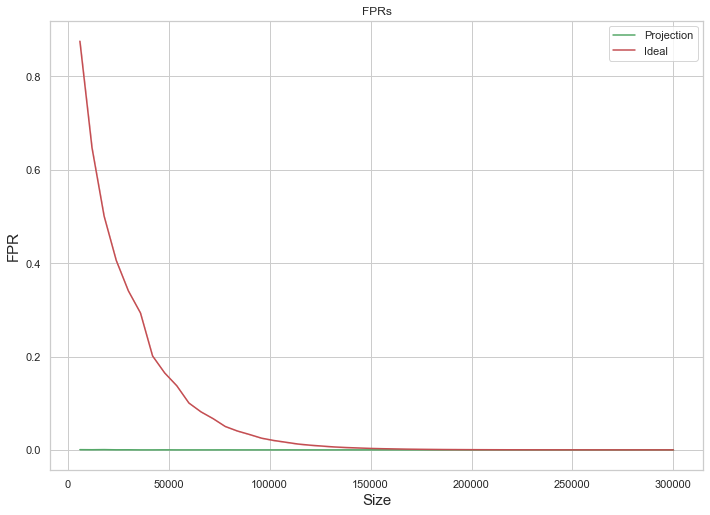

In [26]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
sns.lineplot(x=size_values, y=y_ideal, err_style="band",label = "Ideal",linewidth = 1.5,color="r")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

In [27]:
average_fprs = num_of_iterations*average_fprs
print(len(average_fprs))

150


In [28]:
average_times = num_of_iterations*average_times
print(len(average_times))

150


In [29]:
print(average_fprs)

[0.00048, 0.00032, 0.0005866666666666667, 0.00016, 0.00021333333333333336, 0.0, 0.0, 0.00010666666666666668, 0.0, 0.0, 0.0, 0.0, 5.333333333333334e-05, 0.0, 0.0, 0.0, 0.0, 5.333333333333334e-05, 0.0, 0.0, 0.0, 0.0, 5.333333333333334e-05, 0.0, 5.333333333333334e-05, 5.333333333333334e-05, 5.333333333333334e-05, 0.0, 5.333333333333334e-05, 0.0, 5.333333333333334e-05, 0.0002666666666666667, 0.0, 0.0, 0.00016, 5.333333333333334e-05, 5.333333333333334e-05, 0.0, 5.333333333333334e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00010666666666666668, 0.00016, 0.00016, 0.0, 0.00048, 0.00032, 0.0005866666666666667, 0.00016, 0.00021333333333333336, 0.0, 0.0, 0.00010666666666666668, 0.0, 0.0, 0.0, 0.0, 5.333333333333334e-05, 0.0, 0.0, 0.0, 0.0, 5.333333333333334e-05, 0.0, 0.0, 0.0, 0.0, 5.333333333333334e-05, 0.0, 5.333333333333334e-05, 5.333333333333334e-05, 5.333333333333334e-05, 0.0, 5.333333333333334e-05, 0.0, 5.333333333333334e-05, 0.0002666666666666667, 0.0, 0.0, 0.00016, 5.333333333333334e-05, 5.

In [30]:
saved_data = list(zip(size_values, y_ideal, fpr_values, average_fprs, times, average_times))
df = pd.DataFrame(saved_data,columns = ['Size of filter(bits)','Ideal FPR', 'Projection FPR for iteration', 'Average Projection FPR', 'Projection Filter Total Creation Time(sec)', 'Average Projection Filter Total Creation Time(sec)'])
df.head()

,Size of filter(bits),Ideal FPR,Projection FPR for iteration,Average Projection FPR,Projection Filter Total Creation Time(sec),Average Projection Filter Total Creation Time(sec)
0,6000,0.875507,0.00080,0.000480,5.242174,6.881453
1,12000,0.647149,0.00016,0.000320,5.509614,6.303325
2,18000,0.500658,0.00032,0.000587,6.176617,6.425215
3,24000,0.405981,0.00032,0.000160,6.853280,6.806358
4,30000,0.340764,0.00016,0.000213,6.159336,6.622881


In [31]:
df.to_csv('/Users/aditijain/Desktop/NewFolderWithItems/SURA/2D_rerun_epochs_100.csv')